In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pickle
import random
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Load Dataset

####Download dataset and get all the images

In [ ]:
def load_mini_imagenet(data_dir, split='train'):
  assert split in ['train', 'val', 'test']
  split_file = os.path.join(data_dir, f'mini-imagenet-cache-{split}.pkl')

  with open(split_file, 'rb') as f:
    data = pickle.load(f)
  
  images = data['image_data']
  class_labels = data['class_dict']

  return images, class_labels

In [ ]:
data_dir = '/content/drive/MyDrive/ECE 50024/final-project/mini-imagenet'
train_images, train_labels = load_mini_imagenet(data_dir, split='train')
val_images, val_labels = load_mini_imagenet(data_dir, split='val')
test_images, test_labels = load_mini_imagenet(data_dir, split='test')

In [ ]:
print(len(train_images), len(val_labels), len(test_labels))

38400 16 20


In [ ]:
def create_few_shot_task(images, class_labels, n_classes, k_shots, q_queries):
    unique_labels = list(class_labels.keys())

    # Select N random classes
    selected_classes = random.sample(unique_labels, n_classes)

    sampled_sets = []
    for idx, cls in enumerate(selected_classes):
        # Get all images of the selected class
        cls_images = class_labels[cls]

        # Randomly select K + Q images for the class without replacement
        if idx < q_queries:
            sampled_images = random.sample(cls_images, k_shots + q_queries)
        else:
            sampled_images = random.sample(cls_images, k_shots)

        # Add the sampled images to the list of sampled_sets
        sampled_sets.append(sampled_images)

    # Create support set
    support_set = []
    query_set = []
    support_set_labels = []
    query_set_labels = []
    for idx, sampled_set in enumerate(sampled_sets):
        if idx < q_queries:
            # Divide the sampled set into support and query sets
            support_set.extend(sampled_set[:k_shots])
            query_set.extend(sampled_set[k_shots:])
            # Assign labels
            support_set_labels.extend([selected_classes[idx] for i in range(k_shots)])
            query_set_labels.extend([selected_classes[idx] for i in range(q_queries)])
        else:
            # Add all elements
            support_set.extend(sampled_set)
            # Assign labels
            support_set_labels.extend([selected_classes[idx] for i in range(k_shots)])

    # Get the image data for the support and query sets
    support_set_data = images[support_set]
    query_set_data = images[query_set]

    return support_set_data, support_set_labels, query_set_data, query_set_labels

In [ ]:
n_classes = 5
k_shots = 3
q_queries = 2
support_set_data, support_set_labels, query_set_data, query_set_labels = create_few_shot_task(train_images, train_labels, n_classes, k_shots, q_queries)

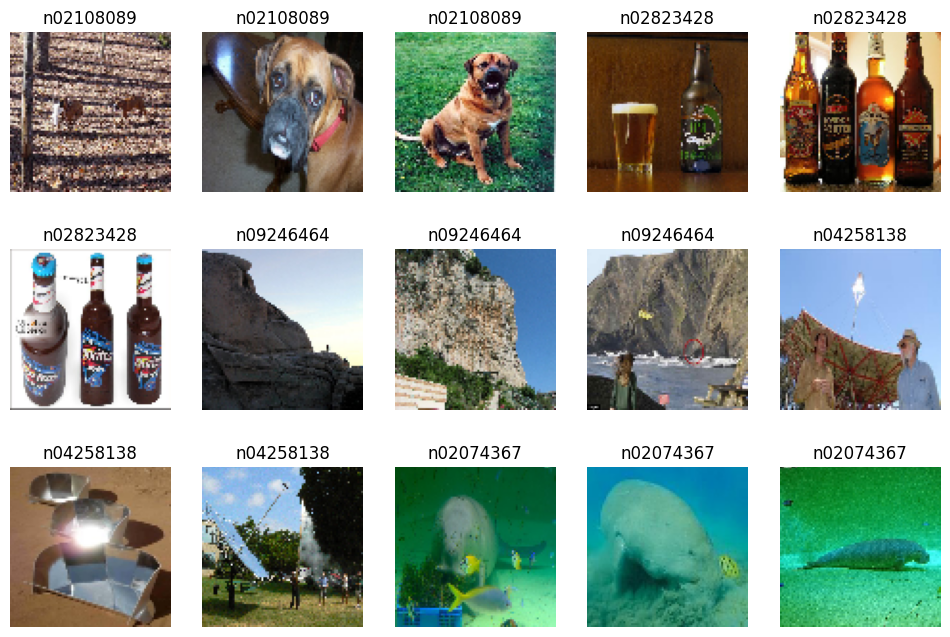

In [ ]:
fig, axes = plt.subplots(nrows=k_shots, ncols=n_classes, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(support_set_data[i])
    ax.set_title(support_set_labels[i])
    ax.axis('off')
plt.show()

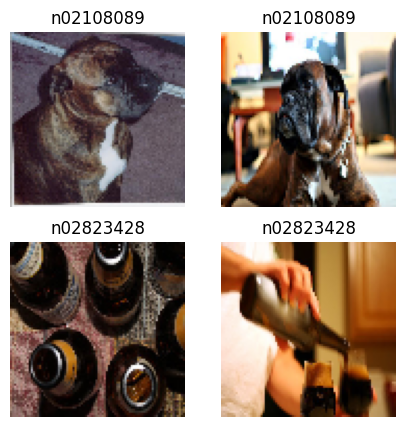

In [ ]:
fig, axes = plt.subplots(nrows=q_queries, ncols=q_queries, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(query_set_data[i])
    ax.set_title(query_set_labels[i])
    ax.axis('off')
plt.show()

In [ ]:
def generate_meta_learning_tasks(images, class_labels, n_classes, k_shots, q_queries, num_tasks):
    tasks = []
    for _ in range(num_tasks):
        task = create_few_shot_task(images, class_labels, n_classes, k_shots, q_queries)
        tasks.append(task)
    return tasks

### Create Models

In [ ]:
def create_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
def create_lstm(input_shape, hidden_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(hidden_units),
        tf.keras.layers.Dense(input_shape[-1])
    ])
    return model


In [ ]:
def compute_gradients(model, inputs, targets, loss_function, clip_value=1.0):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_function(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    clipped_gradients = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in gradients]
    return clipped_gradients

In [ ]:
def apply_gradients(model, gradients):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
def train_meta_learning_task(task, cnn, lstm, n_classes, k_shots, q_queries):
    support_data, support_labels, query_data, query_labels = task

    support_labels = le.fit_transform(support_labels)
    query_labels = le.fit_transform(query_labels)

    support_data = support_data.astype(np.float32) / 255.0
    query_data = query_data.astype(np.float32) / 255.0

    
    # Reshape the data to match the input shape of the CNN model
    support_data = support_data.reshape((-1, *input_shape))
    query_data = query_data.reshape((-1, *input_shape))

    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

    # Compute the gradients for the support set
    support_gradients = compute_gradients(cnn, support_data, support_labels, loss_function)

    # Flatten gradients and concatenate them
    flat_gradients = [tf.reshape(grad, [-1]) for grad in support_gradients]
    concatenated_gradients = tf.concat(flat_gradients, axis=0)

    # Add the extra dimension for timestep and expand dimensions to feed into LSTM
    lstm_input = tf.expand_dims(tf.expand_dims(concatenated_gradients, axis=0), axis=1)

    # Compute the update steps using the LSTM
    update_steps = lstm(lstm_input)

    # Split the output back into the original gradient shapes
    split_indices = [tf.reduce_prod(var.shape) for var in cnn.trainable_variables]
    update_steps_list = tf.split(update_steps, split_indices, axis=-1)
    reshaped_update_steps = [tf.reshape(update_step, var.shape) for update_step, var in zip(update_steps_list, cnn.trainable_variables)]

    # Apply the update steps to the CNN
    apply_gradients(cnn, reshaped_update_steps)

    # Evaluate the model on the query set
    query_predictions = cnn(query_data)
    query_loss = loss_function(query_labels, query_predictions)
    query_accuracy = tf.keras.metrics.Accuracy()
    query_accuracy.update_state(query_labels, tf.argmax(query_predictions, axis=-1))

    return query_loss.numpy(), query_accuracy.result().numpy()

In [ ]:
def validate_meta_learning_task(task, cnn, lstm, n_classes, k_shots, q_queries):
    support_data, support_labels, query_data, query_labels = task

    support_labels = le.fit_transform(support_labels)
    query_labels = le.fit_transform(query_labels)

    support_data = support_data.astype(np.float32) / 255.0
    query_data = query_data.astype(np.float32) / 255.0

    support_data = support_data.reshape((-1, *input_shape))
    query_data = query_data.reshape((-1, *input_shape))

    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

    support_gradients = compute_gradients(cnn, support_data, support_labels, loss_function)

    flat_gradients = [tf.reshape(grad, [-1]) for grad in support_gradients]
    concatenated_gradients = tf.concat(flat_gradients, axis=0)

    lstm_input = tf.expand_dims(tf.expand_dims(concatenated_gradients, axis=0), axis=1)

    update_steps = lstm(lstm_input)

    split_indices = [tf.reduce_prod(var.shape) for var in cnn.trainable_variables]
    update_steps_list = tf.split(update_steps, split_indices, axis=-1)
    reshaped_update_steps = [tf.reshape(update_step, var.shape) for update_step, var in zip(update_steps_list, cnn.trainable_variables)]

    apply_gradients(cnn, reshaped_update_steps)

    query_predictions = cnn(query_data)
    query_loss = loss_function(query_labels, query_predictions)
    query_accuracy = tf.keras.metrics.Accuracy()
    query_accuracy.update_state(query_labels, tf.argmax(query_predictions, axis=-1))

    return query_loss.numpy(), query_accuracy.result().numpy()

### Train Model

In [ ]:
input_shape = (84, 84, 3)
num_classes = 5
hidden_units = 128

cnn = create_cnn(input_shape, num_classes)
lstm = create_lstm(input_shape=(1, sum([tf.reduce_prod(var.shape) for var in cnn.trainable_variables])), hidden_units=hidden_units)

In [ ]:
num_epochs = 10
n_classes = 5
k_shots = 1
q_queries = 2
num_tasks = 50

# Generate training tasks
train_images, train_labels = load_mini_imagenet(data_dir, split='train')
tasks = generate_meta_learning_tasks(train_images, train_labels, n_classes, k_shots, q_queries, num_tasks)

# Generate validation tasks
val_images, val_labels = load_mini_imagenet(data_dir, split='val')
val_num_tasks = 10
val_tasks = generate_meta_learning_tasks(val_images, val_labels, n_classes, k_shots, q_queries, val_num_tasks)

In [ ]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    
    # Training loop
    total_train_loss = 0
    total_train_acc = 0
    with tqdm(total=len(tasks), desc="Training", ncols=100) as pbar:
      for i, task in enumerate(tasks):
          task_loss, task_acc = train_meta_learning_task(task, cnn, lstm, n_classes, k_shots, q_queries)
          total_train_loss += task_loss
          total_train_acc += task_acc

          pbar.set_postfix(train_loss=f"{total_train_loss / (i + 1):.4f}", train_accuracy=f"{total_train_acc / (i + 1):.4f}")
          pbar.update(1)
    print(f"Epoch {epoch+1} - train_loss: {total_train_loss / len(tasks):.4f}, train_accuracy: {total_train_acc / len(tasks):.4f}")


    # Validation loop
    total_val_loss = 0
    total_val_acc = 0
    for i, task in enumerate(val_tasks):
        task_loss, task_acc = validate_meta_learning_task(task, cnn, lstm, n_classes, k_shots, q_queries)
        total_val_loss += task_loss
        total_val_acc += task_acc
    print(f"Epoch {epoch+1} - val_loss: {total_val_loss / len(val_tasks):.4f}, val_accuracy: {total_val_acc / len(val_tasks):.4f}\n")

    # Add metrics
    train_loss.append(total_train_loss / len(tasks))
    train_acc.append(total_train_acc / len(tasks))
    valid_loss.append(total_val_loss / len(val_tasks))
    valid_acc.append(total_val_acc / len(val_tasks))

Epoch 1/10


Training: 100%|███████████| 50/50 [00:42<00:00,  1.17it/s, train_accuracy=0.3900, train_loss=1.5828]


Epoch 1 - train_loss: 1.5828, train_accuracy: 0.3900
Epoch 1 - val_loss: 1.5602, val_accuracy: 0.3750

Epoch 2/10


Training: 100%|███████████| 50/50 [00:39<00:00,  1.27it/s, train_accuracy=0.3100, train_loss=1.5561]


Epoch 2 - train_loss: 1.5561, train_accuracy: 0.3100
Epoch 2 - val_loss: 1.5139, val_accuracy: 0.4750

Epoch 3/10


Training: 100%|███████████| 50/50 [00:43<00:00,  1.15it/s, train_accuracy=0.3450, train_loss=1.5346]


Epoch 3 - train_loss: 1.5346, train_accuracy: 0.3450
Epoch 3 - val_loss: 1.4815, val_accuracy: 0.3500

Epoch 4/10


Training: 100%|███████████| 50/50 [00:39<00:00,  1.27it/s, train_accuracy=0.3600, train_loss=1.5344]


Epoch 4 - train_loss: 1.5344, train_accuracy: 0.3600
Epoch 4 - val_loss: 1.4566, val_accuracy: 0.3750

Epoch 5/10


Training: 100%|███████████| 50/50 [00:38<00:00,  1.28it/s, train_accuracy=0.3350, train_loss=1.5495]


Epoch 5 - train_loss: 1.5495, train_accuracy: 0.3350
Epoch 5 - val_loss: 1.4551, val_accuracy: 0.4000

Epoch 6/10


Training: 100%|███████████| 50/50 [00:38<00:00,  1.29it/s, train_accuracy=0.2950, train_loss=1.5892]


Epoch 6 - train_loss: 1.5892, train_accuracy: 0.2950
Epoch 6 - val_loss: 1.4838, val_accuracy: 0.3500

Epoch 7/10


Training: 100%|███████████| 50/50 [00:38<00:00,  1.31it/s, train_accuracy=0.2900, train_loss=1.6536]


Epoch 7 - train_loss: 1.6536, train_accuracy: 0.2900
Epoch 7 - val_loss: 1.5272, val_accuracy: 0.3500

Epoch 8/10


Training: 100%|███████████| 50/50 [00:38<00:00,  1.31it/s, train_accuracy=0.3200, train_loss=1.7390]


Epoch 8 - train_loss: 1.7390, train_accuracy: 0.3200
Epoch 8 - val_loss: 1.5713, val_accuracy: 0.3750

Epoch 9/10


Training: 100%|███████████| 50/50 [00:38<00:00,  1.29it/s, train_accuracy=0.3450, train_loss=1.8363]


Epoch 9 - train_loss: 1.8363, train_accuracy: 0.3450
Epoch 9 - val_loss: 1.6018, val_accuracy: 0.3750

Epoch 10/10


Training: 100%|███████████| 50/50 [00:38<00:00,  1.30it/s, train_accuracy=0.3400, train_loss=1.9397]


Epoch 10 - train_loss: 1.9397, train_accuracy: 0.3400
Epoch 10 - val_loss: 1.6570, val_accuracy: 0.3750



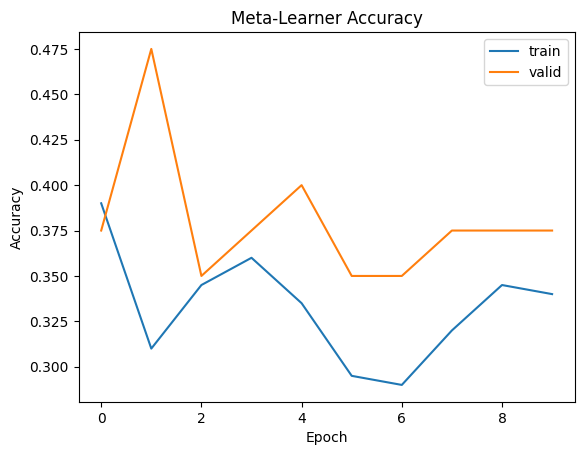

In [ ]:
plt.plot(train_acc, label="train")
plt.plot(valid_acc, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Meta-Learner Accuracy")
plt.show()

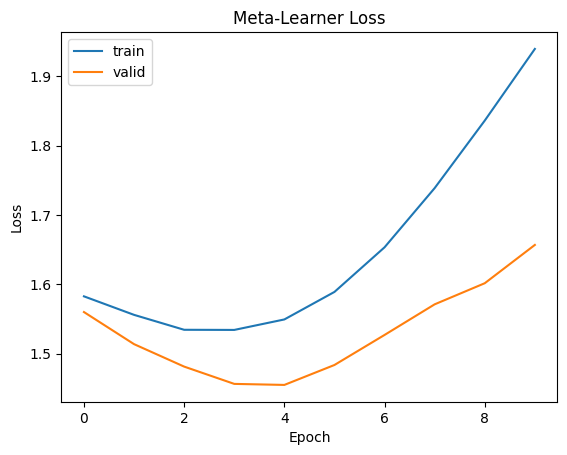

In [ ]:
plt.plot(train_loss, label="train")
plt.plot(valid_loss, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Meta-Learner Loss")
plt.legend()
plt.show()

### Save model

In [ ]:
# Save the models
cnn.save_weights('/content/drive/MyDrive/ECE 50024/final-project/cnn_weights512.h5')
lstm.save_weights('/content/drive/MyDrive/ECE 50024/final-project/lstm_weights512.h5')

Run on test set

In [ ]:
def inference_meta_learning_task(task, cnn, lstm, n_classes, k_shots, q_queries):
    support_data, support_labels, query_data, query_labels = task

    support_labels = le.fit_transform(support_labels)
    query_labels = le.fit_transform(query_labels)

    support_data = support_data.astype(np.float32) / 255.0
    query_data = query_data.astype(np.float32) / 255.0

    support_data = support_data.reshape((-1, *input_shape))
    query_data = query_data.reshape((-1, *input_shape))

    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

    support_gradients = compute_gradients(cnn, support_data, support_labels, loss_function)

    flat_gradients = [tf.reshape(grad, [-1]) for grad in support_gradients]
    concatenated_gradients = tf.concat(flat_gradients, axis=0)

    lstm_input = tf.expand_dims(tf.expand_dims(concatenated_gradients, axis=0), axis=1)

    update_steps = lstm(lstm_input)

    split_indices = [tf.reduce_prod(var.shape) for var in cnn.trainable_variables]
    update_steps_list = tf.split(update_steps, split_indices, axis=-1)
    reshaped_update_steps = [tf.reshape(update_step, var.shape) for update_step, var in zip(update_steps_list, cnn.trainable_variables)]

    apply_gradients(cnn, reshaped_update_steps)

    query_predictions = cnn(query_data)
    
    return tf.argmax(query_predictions, axis=-1).numpy(), query_labels

In [ ]:
n_classes = 5
k_shots = 1
q_queries = 5
test_num_tasks = 50
test_images, test_labels = load_mini_imagenet(data_dir, split='test')
test_tasks = generate_meta_learning_tasks(test_images, test_labels, n_classes, k_shots, q_queries, test_num_tasks)

In [ ]:
avg_acc = []
for i, task in enumerate(test_tasks):
  predicted_labels, true_labels = inference_meta_learning_task(task, cnn, lstm, n_classes, k_shots, q_queries)
  acc = np.sum(predicted_labels == true_labels) / len(true_labels)
  print("Task: {:<6d}  Test acc: {:<10.2f}".format(i, acc))
  avg_acc.append(acc)

print("---------------------------")
print("Overall Accuracy: {:<10.2f}".format(np.mean(avg_acc)))

Task: 0       Test acc: 0.20      
Task: 1       Test acc: 0.24      
Task: 2       Test acc: 0.28      
Task: 3       Test acc: 0.24      
Task: 4       Test acc: 0.08      
Task: 5       Test acc: 0.04      
Task: 6       Test acc: 0.16      
Task: 7       Test acc: 0.24      
Task: 8       Test acc: 0.20      
Task: 9       Test acc: 0.28      
Task: 10      Test acc: 0.20      
Task: 11      Test acc: 0.16      
Task: 12      Test acc: 0.20      
Task: 13      Test acc: 0.24      
Task: 14      Test acc: 0.12      
Task: 15      Test acc: 0.24      
Task: 16      Test acc: 0.20      
Task: 17      Test acc: 0.24      
Task: 18      Test acc: 0.28      
Task: 19      Test acc: 0.20      
Task: 20      Test acc: 0.24      
Task: 21      Test acc: 0.24      
Task: 22      Test acc: 0.24      
Task: 23      Test acc: 0.32      
Task: 24      Test acc: 0.32      
Task: 25      Test acc: 0.28      
Task: 26      Test acc: 0.28      
Task: 27      Test acc: 0.20      
Task: 28      Test a

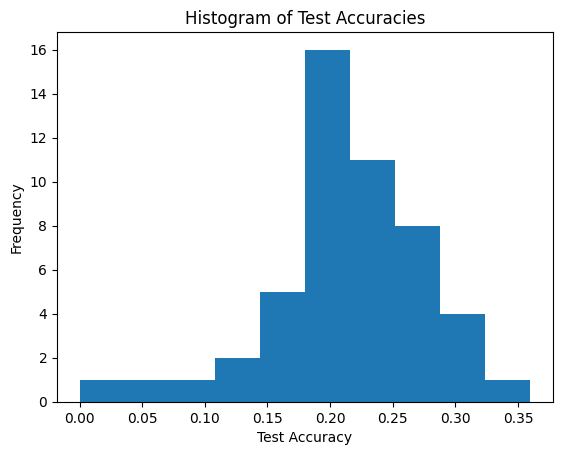

In [ ]:
plt.hist(avg_acc, bins=10)
plt.xlabel('Test Accuracy')
plt.ylabel('Frequency')
plt.title('Histogram of Test Accuracies')
plt.show()

In [ ]:
with open('avg_acc_META_nkp_512.pkl', 'wb') as f:
    pickle.dump(avg_acc, f)